In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from data_utils import (
    read_files,
    results2df,
)
from torchmetrics.functional.classification import (
    multilabel_average_precision,
)

plt.style.use("science")

**Load annotations and results**

In [2]:
# model name
model_name = "slow_r50"
folder_path = "../dataset/results/training_progression"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segments.txt"
figure_saving_path = "../figures/training_progression"


splits = [
    "train",
    "validation",
]

# create saving directory
if not os.path.exists(figure_saving_path):
    os.makedirs(figure_saving_path)


# list all result files in the folder which end with .pkl and contain the model name
result_info = {}

for split in splits:
    for file in os.listdir(os.path.join(folder_path, split)):
        if file.endswith(".pkl") and model_name in file:
            epoch = file.split("_")[-2].split("-")[-1]

            # get the split from the file name
            data_split = file.split("=")[-1].split(".")[0]

            # add model to the dictionary
            if model_name not in result_info:
                result_info[model_name] = {}
            # add epoch to the dictionary
            if epoch not in result_info[model_name]:
                result_info[model_name][epoch] = {}
            if split not in result_info[model_name][epoch]:
                result_info[model_name][epoch][data_split] = {}
            result_info[model_name][epoch][data_split] = {
                "file_path": os.path.join(folder_path, split, file),
            }

In [3]:
metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

# build dict for behavioural where key is the segment and value is the behaviour is the same index
behavioural_dict = {}
for i, (b, s) in enumerate(zip(behaviours, segments)):
    if s not in behavioural_dict:
        behavioural_dict[s] = []
    behavioural_dict[s].append(b)

In [4]:
def return_ct_location(df):
    """
    Returns the location segments based on the given dataframe and thresholds.

    Args:
        df (pandas.DataFrame): The input dataframe containing the location data.
        head (int, optional): The threshold percentage for selecting locations that make up the top percentage of data. Defaults to 50.
        tail (int, optional): The threshold count for selecting locations outside the top percentage with more than this count. Defaults to 10.

    Returns:
        tuple: A tuple containing three dataframes:
            - head_locations: Dataframe containing the top locations and their video counts.
            - tail_locations: Dataframe containing the locations outside the top percentage with more than the tail count.
            - few_shot_locations: Dataframe containing the locations with fewer than the tail count.
    """
    # Group by 'utm' and count the number of videos for each location
    location_counts = df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )
    return location_counts


def calculate_all_metrics(segment, camera_loc_list, show_per_class=False):
    metrics = {}
    for camera_loc in camera_loc_list:
        subset_df = segment[segment["utm"] == str(camera_loc)]

        # metrics[f"avg_map_{camera_loc}"],
        metrics[camera_loc] = calculate_metrics(
            df=subset_df,
            show_per_class=show_per_class,
        )
    return metrics


def print_per_segment_performance(
    map,
    behaviour_list,
    camera_list,
    segment,
    show_per_behaviour_class=True,
    show_per_camera_class=True,
):
    res = []
    print(segment)

    for i, (b, s) in enumerate(zip(map, camera_list)):
        # if s == segment:
        res.append({behaviour_list[i]: b})
    agg_values = []

    for r in res:
        for _, value in r.items():
            agg_values.append(value)

    if show_per_behaviour_class:
        return {
            segment: {
                "mean": np.round(np.mean(agg_values), 3),
                "values": res,
            }
        }
    else:
        return {
            segment: {
                "mean": np.round(np.mean(agg_values), 3),
            }
        }


def print_per_camera_location_performance(
    map,
    behaviour_list,
    camera_location_list,
    camera_location,
    show_per_class=True,
):
    res = []
    # print(camera_location)

    for i, (b, s) in enumerate(zip(map, camera_location_list)):
        if s == camera_location:
            res.append({behaviour_list[i]: b})
    agg_values = []

    for r in res:
        for _, value in r.items():
            agg_values.append(value)

    if show_per_class:
        return {
            camera_location: {
                "mean": np.round(np.mean(agg_values), 3),
                "values": res,
            }
        }
    else:
        return {
            camera_location: {
                "mean": np.round(np.mean(agg_values), 3),
            }
        }


def calculate_metrics(df, round_to=3, show_per_class=True):
    map_values = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])),
        num_labels=14,
        average="none",
    )
    avg_map = round(map_values.mean().item(), round_to)
    if show_per_class:
        return map_values
    return avg_map

In [5]:
labels = ["Head", "Tail", "Few-shot"]
reordered_behaviours = [
    "resting",
    "travel",
    "bipedal",
    "camera_reaction",
    "climbing",
    "feeding",
    "grooming",
    "object_carrying",
    "tool_use",
    "vocalisation",
    "aggression",
    "display",
    "piloerection",
    "playing",
]


# Merge behavior data into final_train_data
# "h", "t", "f" are the segments of camera locations
# "head", "tail", "few_shot" are the segments of behaviors
# so if we have a key "map_h_head_values" it means that the values are for the head segment of the camera locations and the head segment of the behaviors
# Here we aggregate the values of the behaviors for each segment of the camera locations


datas = {}


for m in result_info:
    for epoch in result_info[m]:
        if epoch == "100":
            train_data, val_data = read_files(result_info[model_name], epoch)
            train_df, val_df = results2df(train_data, val_data, metadata_df)

            train_segments = {}
            val_segments = {}

            # Modified segment calculations
            t_df = return_ct_location(train_df)
            v_df = val_df[val_df["utm"].isin(t_df["utm"])]
            # remove the camera locations from v_df that are not in the training set

            val_segments = v_df

            train_segments = t_df.merge(train_df, on="utm", how="left")
            train_camera_loc_list = train_segments["utm"].value_counts().index

            # choose the camera locations that are in the training set
            val_segments = val_segments[val_segments["utm"].isin(train_camera_loc_list)]
            val_segments = val_segments.sort_values("location_count", ascending=False)
            val_camera_loc_list = val_segments["utm"].value_counts().index

            # diff = set(val_camera_loc_list) - set(train_camera_loc_list)

            # print(
            #    val_segments[
            #        ~val_segments["utm"].isin(train_camera_loc_list)
            #    ]
            # )

            train_metrics = calculate_all_metrics(
                train_segments, train_camera_loc_list, show_per_class=True
            )

            val_metrics = calculate_all_metrics(
                val_segments, val_camera_loc_list, show_per_class=True
            )

/home/kukushkin/anaconda3/envs/slowfast/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [6]:
# val_df.merge(train_df[])

val_df.utm.value_counts()

utm
0216558_0056315    112
0807877_9881958     76
0809865_9882811     39
0336939_0191979     36
0807583_9883188     34
                  ... 
0522247_0588613      1
0523660_0589389      1
0806025_9882697      1
0543901_0818132      1
0217712_0053075      1
Name: count, Length: 188, dtype: int64

In [7]:
train_camera_loc_list = train_df.utm.value_counts().index
val_camera_loc_list = val_df.utm.value_counts().index

In [8]:
# create matrix where one axis is number of camera locations and the other is number of behaviours
# each cell will contain the average map of the camera location and the behaviour
# the matrix will be used to create a heatmap
# the matrix will be created for the validation set

train_map_matrix = np.zeros((len(train_camera_loc_list), len(behaviours)))
i = 0
for camera_loc in train_metrics:
    # check if camera_loc is list
    if isinstance(train_metrics[camera_loc], torch.Tensor):
        for j, behaviour in enumerate(behaviours):
            if train_metrics[camera_loc][j] == -0.0:
                train_map_matrix[i, j] = 0.0
            else:
                train_map_matrix[i, j] = train_metrics[camera_loc][j]

        i += 1


val_map_matrix = np.zeros((len(val_camera_loc_list), len(behaviours)))

i = 0
for camera_loc in val_metrics:
    if isinstance(val_metrics[camera_loc], torch.Tensor):
        for j, behaviour in enumerate(behaviours):
            if val_metrics[camera_loc][j] == -0.0:
                val_map_matrix[i, j] = 0.0
            else:
                val_map_matrix[i, j] = val_metrics[camera_loc][j]
        i += 1

In [9]:
len(train_camera_loc_list), len(val_camera_loc_list)

(208, 188)

In [10]:
train_camera_loc_list

Index(['0336939_0191998', '0216558_0056315', '0336939_0191979',
       '0809865_9882811', '0807877_9881958', '0522043_0588350',
       '0215958_0050905', '0336539_0190921', '0337088_0191451',
       '0807384_9884309',
       ...
       '0805572_9885600', '0701824_0597013', '0217443_0052214',
       '0216382_0050822', '0217284_0055634', '0686412_0647491',
       '0697856_0598594', '0805053_9885521', '0805019_9885505',
       '0522522_0587554'],
      dtype='object', name='utm', length=208)

In [11]:
val_camera_loc_list

Index(['0216558_0056315', '0807877_9881958', '0809865_9882811',
       '0336939_0191979', '0807583_9883188', '0522043_0588350',
       '0336939_0191998', '0808601_9883016', '0809842_9882780',
       '0216572_0056318',
       ...
       '0522040_0588366', '0546708_0820696', '0658017_0605813',
       '0805680_9883901', '0659045_0607584', '0522247_0588613',
       '0523660_0589389', '0806025_9882697', '0543901_0818132',
       '0217712_0053075'],
      dtype='object', name='utm', length=188)

Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.10000000000002]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1041 ticks ([0.09999999999999998, ..., 208.100000000

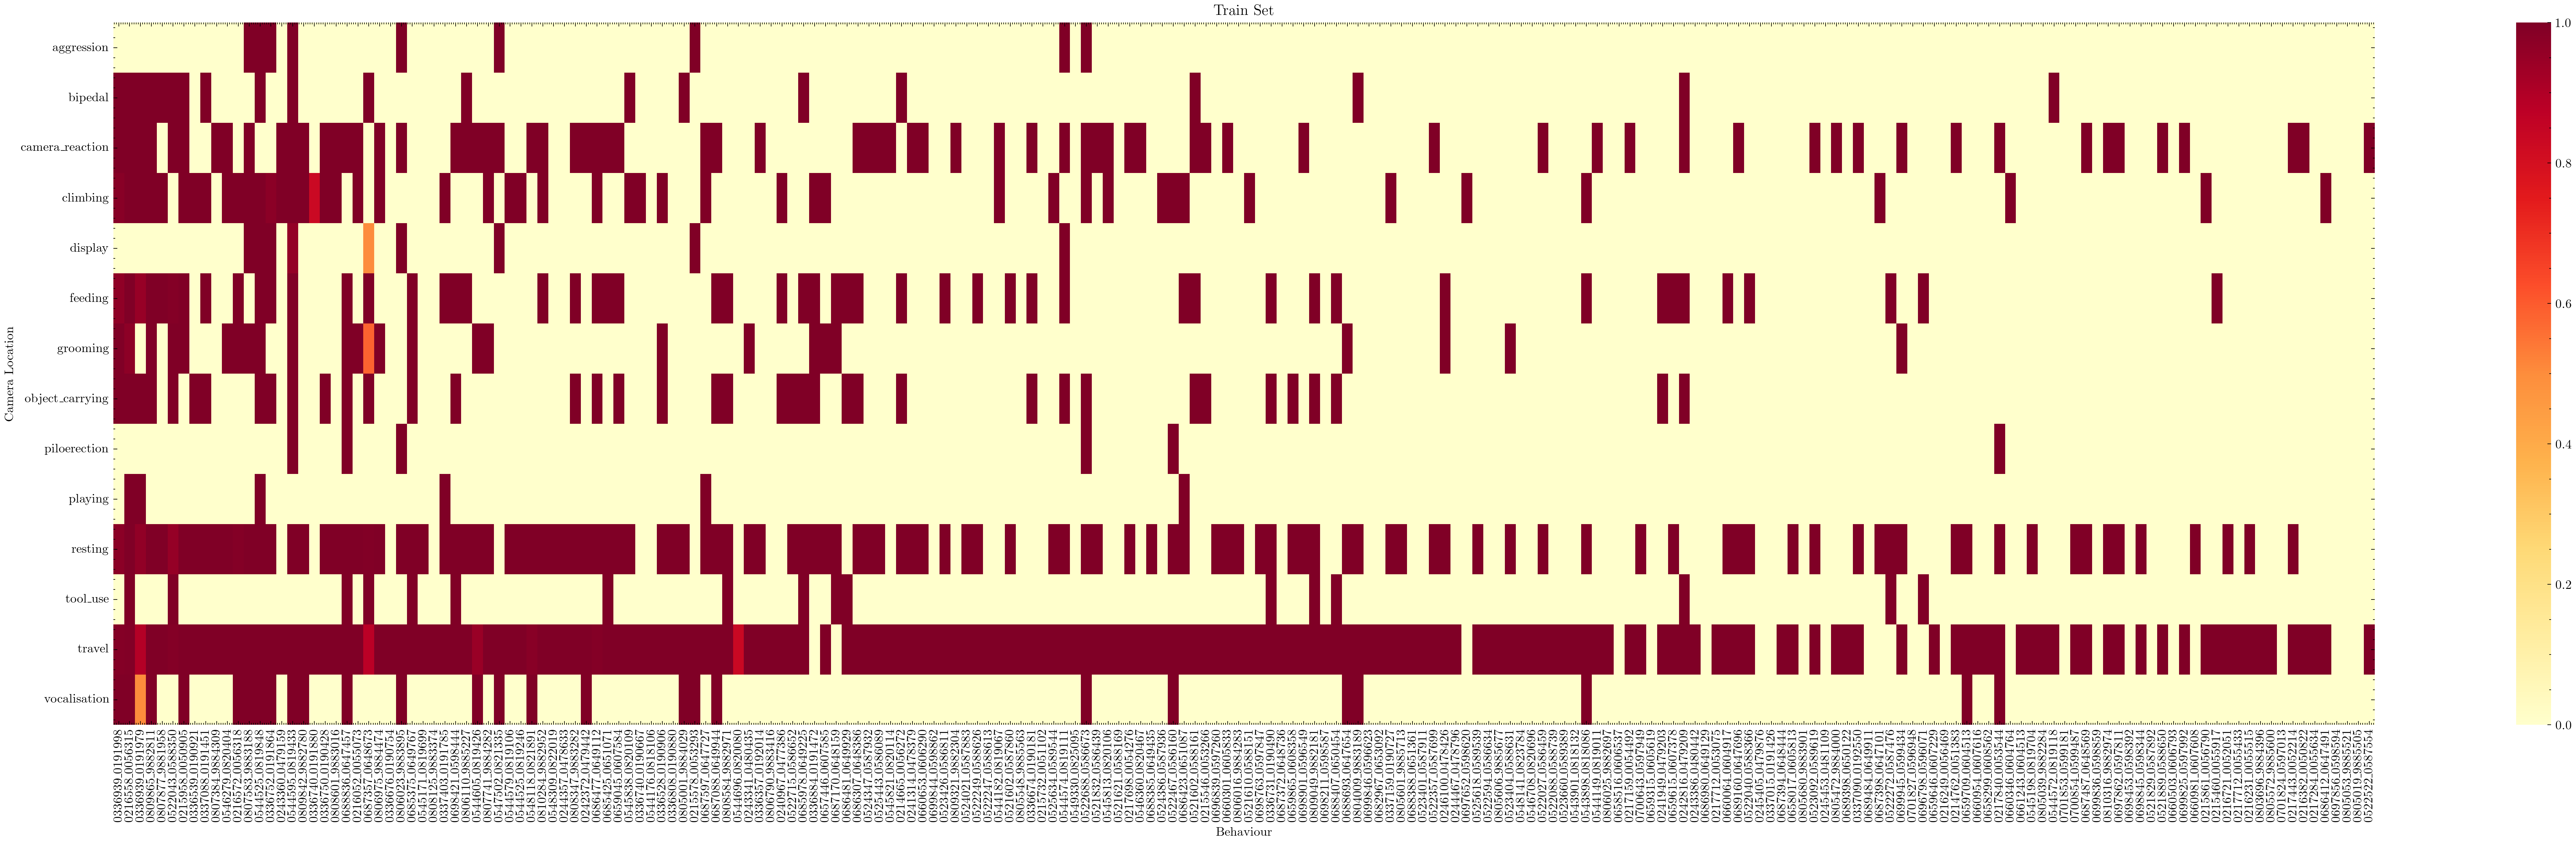

In [12]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(40, 10), dpi=300)
sns.heatmap(
    train_map_matrix.T,
    ax=ax,
    cmap="YlOrRd",
    cbar=True,
    xticklabels=train_camera_loc_list,
    vmin=0,
    yticklabels=behaviours,
)
plt.xlabel("Behaviour")
plt.ylabel("Camera Location")
plt.title("Train Set")
plt.show()

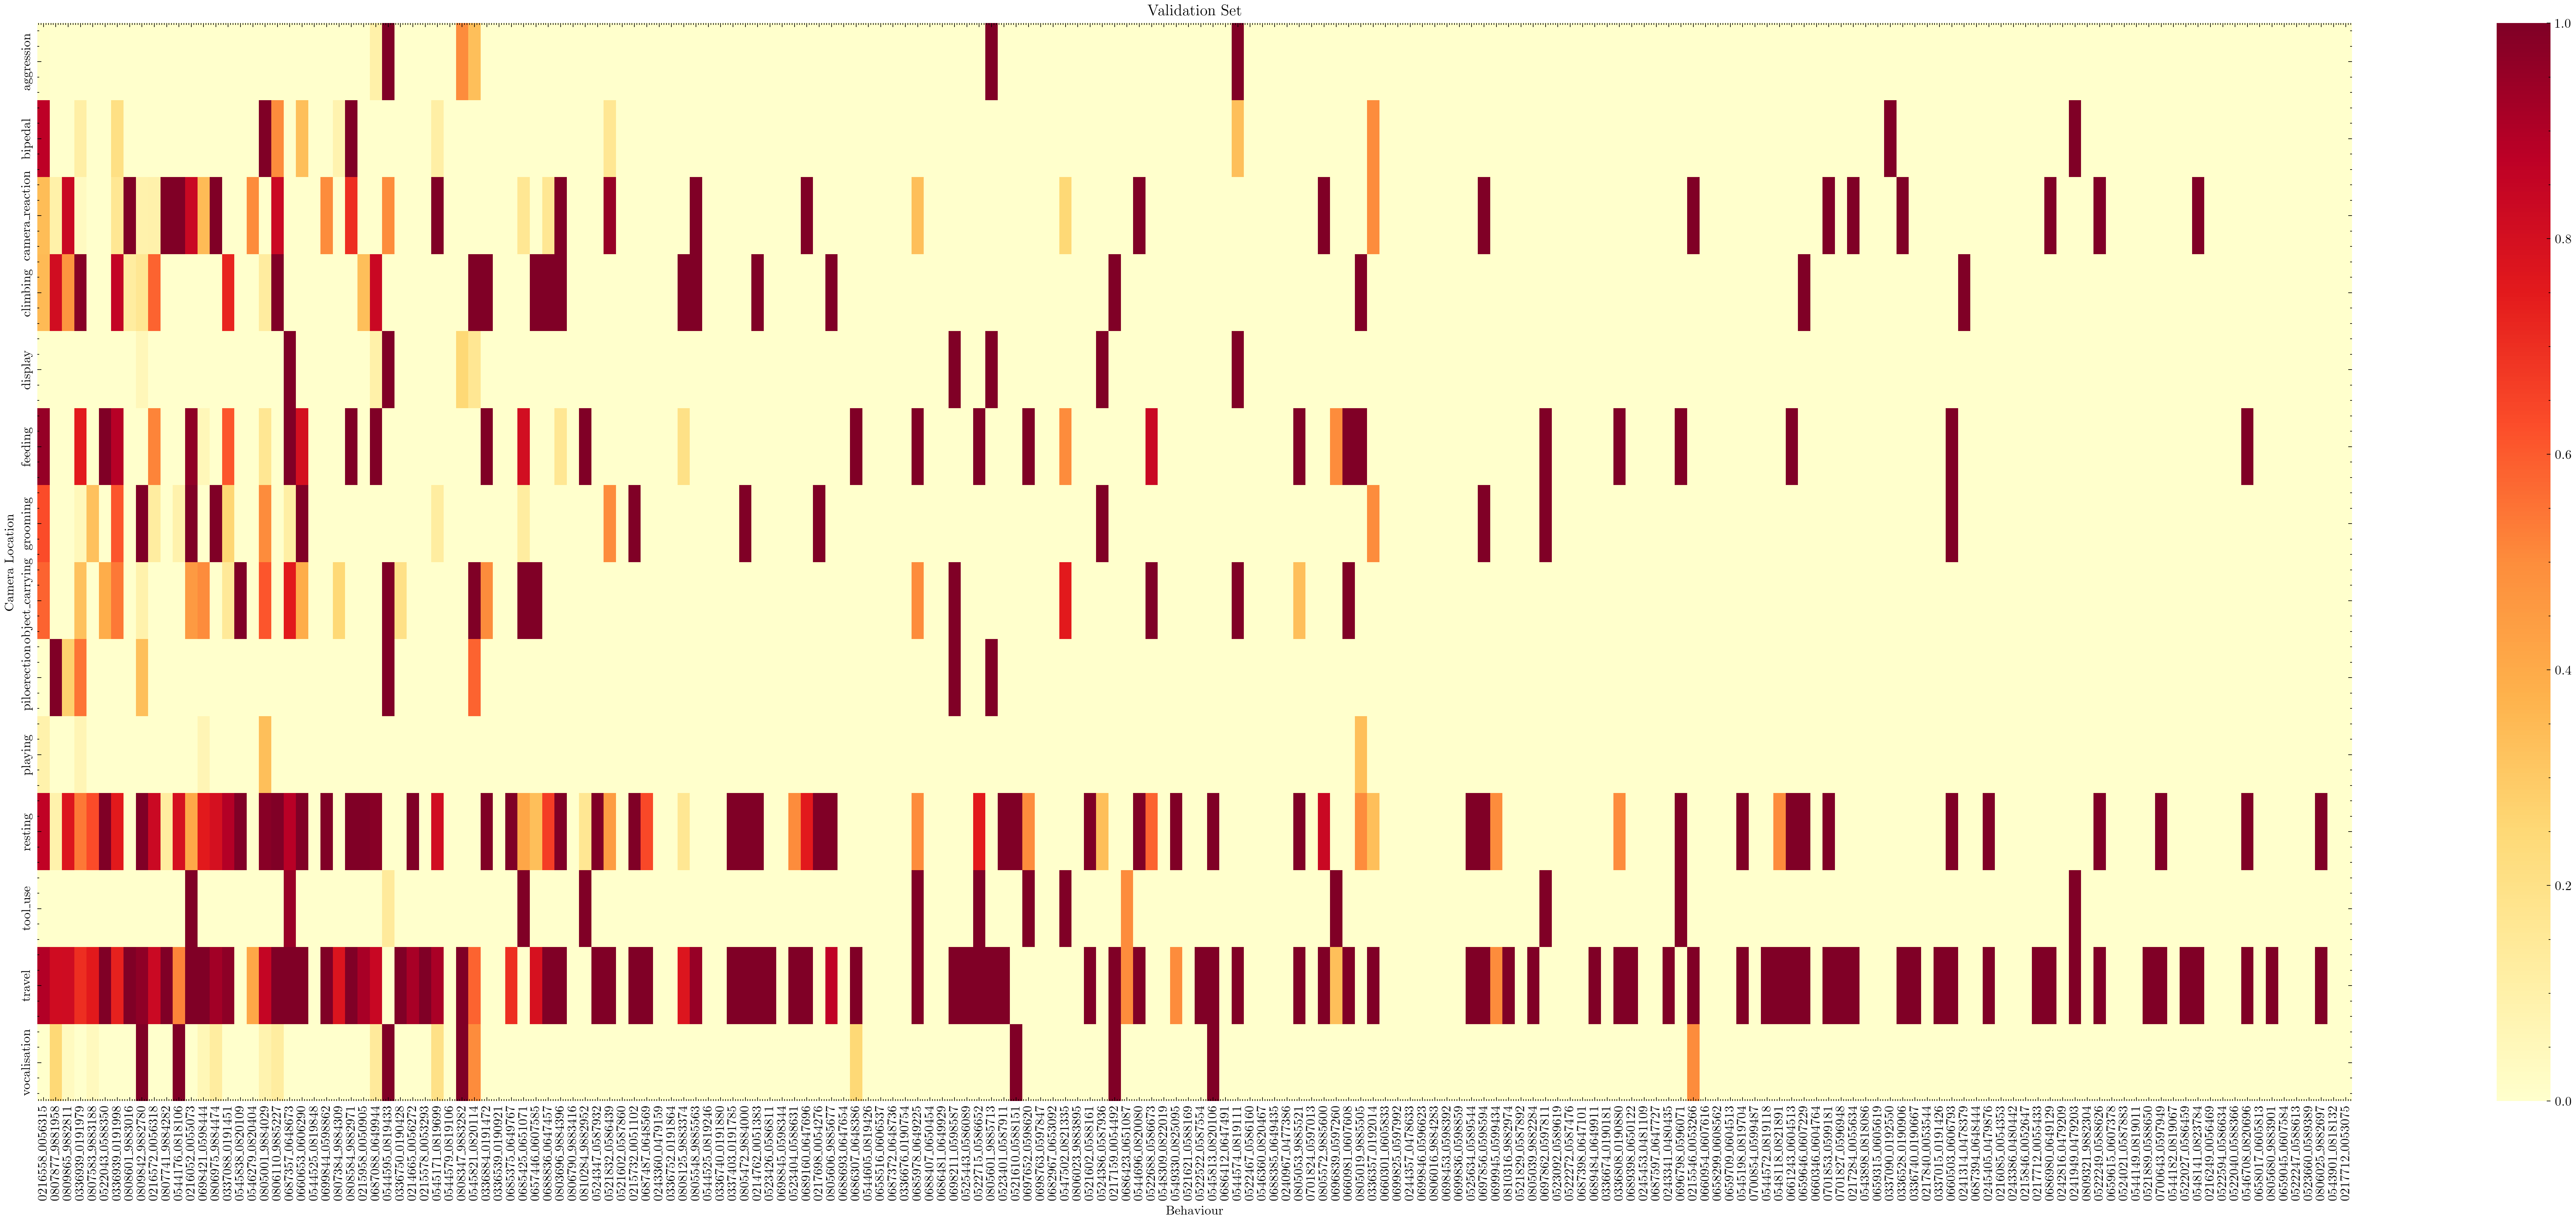

In [13]:
fig, ax = plt.subplots(figsize=(40, 15), dpi=300)
sns.heatmap(
    val_map_matrix.T,
    ax=ax,
    cmap="YlOrRd",
    yticklabels=behaviours,
    xticklabels=val_camera_loc_list,
    cbar=True,
    vmin=0,
)
plt.xlabel("Behaviour")
plt.ylabel("Camera Location")
plt.title("Validation Set")
plt.show()

In [14]:
# extract one row from the matrix
val_map_matrix[:, 0]

# save as numpy array
np.save("val_map_matrix.npy", val_map_matrix[:, 0])